In [8]:
import math
import os
import utils
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from constants import PUNT_TYPES
from constants import DATA_DIR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

Get baseline MAE and RMSE

In [2]:
def avg_errors(punt_type):
    df = utils.csv_concatenate(os.path.join(DATA_DIR,punt_type,'Weighted','base'))
    columns = utils.get_punt_columns([])
    X = df.loc[:, columns]
    y = df['VALUE']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=None)
    mean_train = np.mean(y_train)
    baseline_predictions = np.ones(y_test.shape)*mean_train
    return mae(y_test, baseline_predictions), math.sqrt(mse(y_test, baseline_predictions))

Get linear regression of non-weighted data

In [5]:
def reg_errors(punt, weight):
    df = utils.csv_concatenate(os.path.join(DATA_DIR,punt,'Weighted',weight))
    df.drop(columns=['PLAYER','TEAM','SEASON'], inplace=True)
    df = pd.get_dummies(df)
    X = df.loc[:, df.columns != 'VALUE']
    y = df['VALUE'].values.reshape(-1,1).flatten()
    errors = utils.cross_val(LinearRegression(), X, y, n_folds=3, verbose=0)
    return np.mean(errors['MAE']['valid']), np.mean(errors['RMSE']['valid'])

Across all punting strategies, using the quad dataset seems to yield the smallest RMSE and MAE. As such, this dataset will be used in the next step, which is to select the best algorithm for each punting strategy.

In [9]:
# analyze which weighting is best for each punt type
rmse_table = pd.DataFrame()
mae_table = pd.DataFrame()
weights = ['average','base','sqrt','linear','quad']
for punt in PUNT_TYPES:
    if punt == []:
        punt = 'Base'
    else:
        punt = '+'.join(punt)
    for weight in weights:
        if weight =='average':
            mae_value, rmse_value = avg_errors(punt)
        else:
            mae_value, rmse_value = reg_errors(punt, weight)
        rmse_table.loc[punt, modl.] = rmse_value
        mae_table.loc[punt,weight] = mae_value
print(rmse_table)
print(mae_table)


              reg      base      sqrt    linear      quad
Base     3.967925  2.604070  2.551820  2.518083  2.489750
FG%      3.783763  2.344183  2.293838  2.261239  2.233588
FT%      3.656524  2.373582  2.324427  2.292566  2.265369
PTS      3.141062  2.184786  2.145388  2.120272  2.100069
TRB      3.363155  2.267246  2.227773  2.203231  2.184993
AST      3.449061  2.357961  2.312317  2.282530  2.257308
STL      3.297162  2.221272  2.181266  2.155994  2.135855
BLK      3.539267  2.323391  2.281022  2.254358  2.232904
FG%+TRB  3.237953  1.992653  1.955366  1.932314  1.915349
BLK+FG%  3.432329  2.053353  2.012666  1.986994  1.966108
AST+STL  2.915128  2.005768  1.971486  1.949586  1.932155
PTS+FT%  2.846038  1.945850  1.909623  1.886548  1.867895
              reg      base      sqrt    linear      quad
Base     3.016711  1.931858  1.887532  1.857638  1.829388
FG%      2.945994  1.770451  1.729686  1.700755  1.670846
FT%      2.852230  1.791569  1.749174  1.721933  1.696512
PTS      2.34

Create ABTs for each punt.

In [10]:
for punt in PUNT_TYPES:
    if punt == []:
        punt = 'Base'
    else:
        punt = '+'.join(punt)
    df = utils.csv_concatenate(os.path.join(DATA_DIR,punt,'Weighted','quad'))
    df.drop(columns=['PLAYER','TEAM','SEASON'], inplace=True)
    df = pd.get_dummies(df)
    directory = os.path.join(DATA_DIR,'ABT')
    if not os.path.exists(directory):
        os.makedirs(directory)
    df.to_csv(os.path.join(DATA_DIR,'ABT',punt+'.csv'), index=False)

Here's where we add more features and cut them down with feature selection

In [19]:
#add more features prior to this?
abt = data[0]
abt.to_csv(os.path.join(DATA_DIR,'ABT','all_features.csv'), index=False)

### Feature Selection

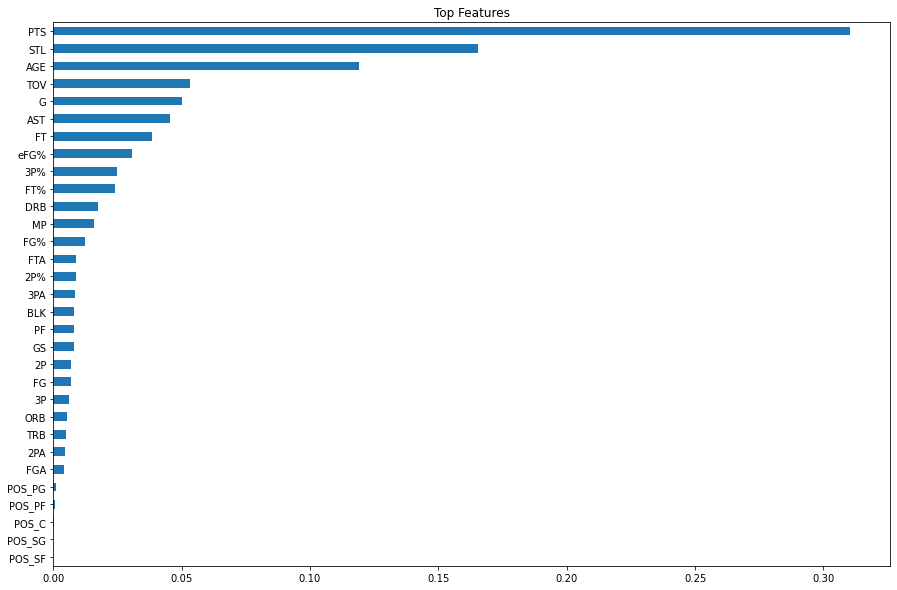

In [20]:
X = abt.loc[:, df.columns != 'VALUE']
y = abt['VALUE']
model = GradientBoostingRegressor()
model.fit(X, y)
column = abt.columns.drop(['VALUE'])
top_features = pd.Series(model.feature_importances_, index = column).sort_values()
top_features.plot(kind = "barh", figsize=(15,10), title='Top Features')
plt.show()

In [21]:
# create ABT
omit_lowest = 8
selected = list(top_features[omit_lowest:].index)
new_abt = abt.loc[:,selected]
new_abt['VALUE'] = y
new_abt.to_csv(os.path.join(DATA_DIR,'ABT','select_features.csv'), index=False)
print(new_abt.shape)

(2519, 24)
